In this notebook we will study the energy conservation properties of several high-order methods for the Hénon–Heiles system. We will se how the energy error behaves at very thight tolerances and how different techniques such as using symplectic solvers or manifold projections benchmark against each other.
The Hamiltonian for this system is given by:
$$
\mathcal{H}=\frac{1}{2}(p_1^2 + p_2^2) + \frac{1}{2}\left(q_1^2 + q_2^2 + 2q_1^2 q_2 - \frac{2}{3}q_2^3\right)
$$

We will also compare the in place apporach with the out of place approach by using `Array`s (for the in place version) and `StaticArrays` (for out of place versions). In order to separate these two, we will define the relevant functions and initial conditions in the `InPlace` and `OutofPlace` modules. In this way the rest of the code will work for both.

In [1]:
using DifferentialEquations, Plots
using TaylorIntegration
pyplot()

T(p) = 1//2 * norm(p)^2
V(q) = 1//2 * (q[1]^2 + q[2]^2 + 2q[1]^2 * q[2]- 2//3 * q[2]^3)
H(q, p) = T(p) + V(q)

module InPlace
using ParameterizedFunctions

function q̇(t, q, p, dq)
    dq[1] = p[1]
    dq[2] = p[2]
end

function ṗ(t, q, p, dp)
    dp[1] = -q[1] * (1 + 2q[2])
    dp[2] = -q[2] - (q[1]^2 - q[2]^2)
end

const q0 = [0.1, 0.]
const p0 = [0., 0.5]
const u0 = vcat(q0, p0)

henon = @ode_def_noinvjac HamiltonEqs begin
    dq1 = p1
    dq2 = p2
    dp1 = -q1 * (1 + 2q2)
    dp2 = -q2 - (q1^2 - q2^2)
end

end

module OutOfPlace
using StaticArrays

function q̇(t, q, p)
    p
end

function ṗ(t, q, p)
    dp1 = -q[1] * (1 + 2q[2])
    dp2 = -q[2] - (q[1]^2 - q[2]^2)
    @SVector [dp1, dp2]
end

const q0 = @SVector [0.1, 0.]
const p0 = @SVector [0., 0.5]
const u0 = vcat(q0, p0)

henon(t, z) = SVector(
    z[3],
    z[4],
    -z[1] * (1 + 2z[2]), 
    -z[2] - (z[1]^2 - z[2]^2)
)

end

function g(u, resid)
    resid[1] = H([u[1],u[2]],[u[3],u[4]]) - E
    resid[2:4] .= 0
end

const cb = ManifoldProjection(g, nlopts=Dict(:ftol=>1e-13))

const E = H(InPlace.q0, InPlace.p0)

0.13

For the comparison we will use the following function.

In [2]:
energy_err(sol) = map(i->H([sol[1,i], sol[2,i]], [sol[3,i], sol[4,i]])-E, 1:length(sol.u))
abs_energy_err(sol) = [abs.(H([sol[1,j], sol[2,j]], [sol[3,j], sol[4,j]]) - E) for j=1:length(sol.u)]

function compare(mode=InPlace, dyn_only=false, plt=nothing; tmax=1e2)
    prob1 = DynamicalODEProblem(mode.q̇, mode.ṗ, mode.q0, mode.p0, (0., tmax))
    if (mode == InPlace && !dyn_only)
        prob2 = ODEProblem(mode.henon, mode.u0, (0., tmax))
    end
    gc()
    (mode == InPlace  && !dyn_only) && @time sol1 = solve(prob2, Vern9(), callback=cb, abstol=1e-14, reltol=1e-14)
    gc()
    @time sol2 = solve(prob1, KahanLi8(), dt=1e-2, maxiters=1e10)
    gc()
    @time sol3 = solve(prob1, SofSpa10(), dt=1e-2)
    gc()
    @time sol4 = solve(prob1, Vern9(), abstol=1e-14, reltol=1e-14)
    gc()
    @time sol5 = solve(prob1, DPRKN12(), abstol=1e-14, reltol=1e-14)
    gc()
    (mode == InPlace && !dyn_only) && @time sol6 = solve(prob2, TaylorMethod(50), abstol=1e-20)
    
    (mode == InPlace && !dyn_only) && println("Vern9 + ManifoldProjection max energy error:\t"*
        "$(maximum(abs_energy_err(sol1)))\tin\t$(length(sol1.u))\tsteps.")
    println("KahanLi8 max energy error:\t\t\t$(maximum(abs_energy_err(sol2)))\tin\t$(length(sol2.u))\tsteps.")
    println("SofSpa10 max energy error:\t\t\t$(maximum(abs_energy_err(sol3)))\tin\t$(length(sol3.u))\tsteps.")
    println("Vern9 max energy error:\t\t\t\t$(maximum(abs_energy_err(sol4)))\tin\t$(length(sol4.u))\tsteps.")
    println("DPRKN12 max energy error:\t\t\t$(maximum(abs_energy_err(sol5)))\tin\t$(length(sol5.u))\tsteps.")
    (mode == InPlace && !dyn_only) && println("TaylorMethod max energy error:\t\t\t$(maximum(abs_energy_err(sol6)))"*
        "\tin\t$(length(sol6.u))\tsteps.")
    
    if plt == nothing
        plt = plot(xlabel="t", ylabel="Energy error")
    end
    (mode == InPlace && !dyn_only) && plot!(sol1.t, energy_err(sol1), label="Vern9 + ManifoldProjection")
    plot!(sol2.t, energy_err(sol2), label="KahanLi8", ls=mode==InPlace?:solid : :dash)
    plot!(sol3.t, energy_err(sol3), label="SofSpa10", ls=mode==InPlace?:solid : :dash)
    plot!(sol4.t, energy_err(sol4), label="Vern9", ls=mode==InPlace?:solid : :dash)
    plot!(sol5.t, energy_err(sol5), label="DPRKN12", ls=mode==InPlace?:solid : :dash)
    (mode == InPlace && !dyn_only) && plot!(sol6.t, energy_err(sol6), label="TaylorMethod")
    
    return plt
end

compare (generic function with 4 methods)

The `mode` argument choses between the in place approach
and the out of place one. The `dyn_only` parameter is used to compare only the integrators that are compatible with
`DynamicalODEProblem` and those coincide with the integrators that support both the in place and the out of place
versions (we reffer here only to the 6 high order methods chosen bellow). The `plt` argument can be used to overlay the results over a previous plot and the `tmax` keyword determines the simulation time.

Note: The `NLsolve` call used by `ManifoldProjection` was modified to use `ftol=1e-13` in order to obtain a very low energy error.

Here are the results of the comparisons between the in place methods:

  0.006843 seconds (56.62 k allocations: 8.331 MiB)
  0.010412 seconds (190.21 k allocations: 10.319 MiB)
  0.016823 seconds (190.20 k allocations: 10.319 MiB)
  0.039261 seconds (1.58 M allocations: 26.838 MiB, 30.71% gc time)
  0.000810 seconds (8.55 k allocations: 394.016 KiB)
  0.023027 seconds (173.95 k allocations: 60.718 MiB, 33.74% gc time)
Vern9 + ManifoldProjection max energy error:	5.551115123125783e-16	in	941	steps.
KahanLi8 max energy error:			4.9404924595819466e-15	in	10001	steps.
SofSpa10 max energy error:			5.440092820663267e-15	in	10001	steps.
Vern9 max energy error:				1.4988010832439613e-15	in	853	steps.
DPRKN12 max energy error:			2.498001805406602e-16	in	329	steps.
TaylorMethod max energy error:			1.942890293094024e-16	in	80	steps.



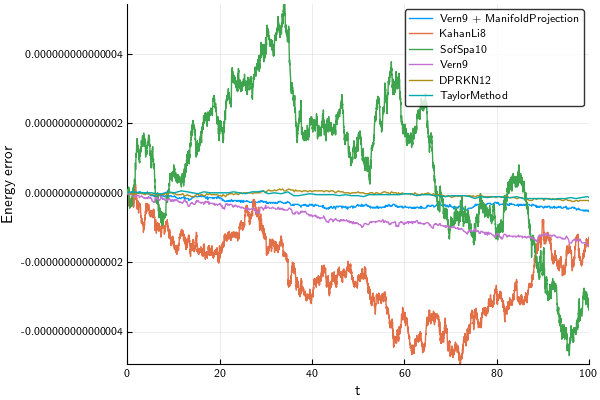

In [4]:
compare(tmax=1e2)

  0.086894 seconds (559.98 k allocations: 82.873 MiB, 24.63% gc time)
  0.249402 seconds (1.90 M allocations: 101.091 MiB, 52.96% gc time)
  0.353766 seconds (1.90 M allocations: 101.091 MiB, 48.64% gc time)
  0.374340 seconds (15.78 M allocations: 267.807 MiB, 37.34% gc time)
  0.004951 seconds (82.21 k allocations: 3.593 MiB)
  0.148279 seconds (1.72 M allocations: 261.793 MiB, 27.40% gc time)
Vern9 + ManifoldProjection max energy error:	5.6066262743570405e-15	in	9330	steps.
KahanLi8 max energy error:			1.815214645262131e-14	in	100002	steps.
SofSpa10 max energy error:			2.8033131371785203e-14	in	100002	steps.
Vern9 max energy error:				1.3933298959045715e-14	in	8475	steps.
DPRKN12 max energy error:			1.0269562977782698e-15	in	3239	steps.
TaylorMethod max energy error:			5.551115123125783e-16	in	784	steps.



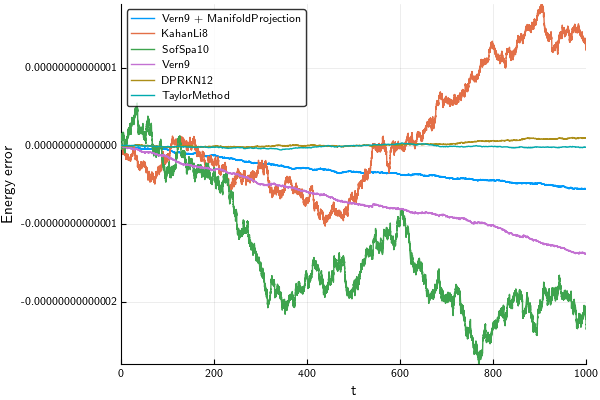

In [5]:
compare(tmax=1e3)

  1.579355 seconds (5.59 M allocations: 825.873 MiB, 59.08% gc time)
  2.726948 seconds (19.00 M allocations: 966.797 MiB, 56.46% gc time)
  5.546326 seconds (19.00 M allocations: 966.797 MiB, 64.54% gc time)
 19.540975 seconds (157.84 M allocations: 2.613 GiB, 82.47% gc time)
  0.073749 seconds (818.97 k allocations: 35.241 MiB, 26.78% gc time)
  4.093249 seconds (17.22 M allocations: 2.220 GiB, 65.47% gc time)
Vern9 + ManifoldProjection max energy error:	4.50195436485501e-14	in	93216	steps.
KahanLi8 max energy error:			3.161360062620133e-14	in	1000001	steps.
SofSpa10 max energy error:			1.136590821460004e-13	in	1000001	steps.
Vern9 max energy error:				1.22291066162461e-13	in	84653	steps.
DPRKN12 max energy error:			1.4988010832439613e-14	in	32348	steps.
TaylorMethod max energy error:			2.7200464103316335e-15	in	7826	steps.



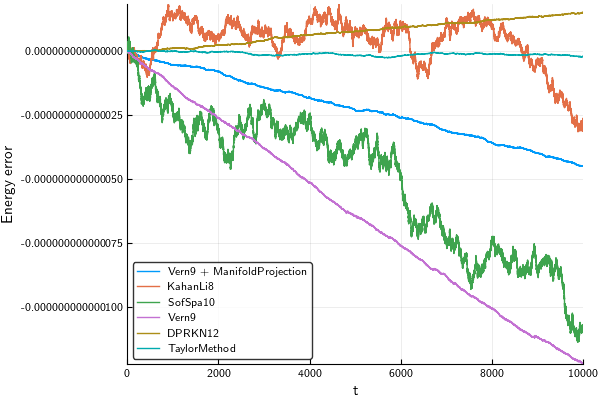

In [6]:
compare(tmax=1e4)

In [ ]:
compare(tmax=5e4)

We can see that as the simulation time increases, the energy error increases. For this particular example the energy error for all the methods is comparable. For relatively short simulation times, if a highly accurate solution is required, the symplectic method is not recommended as its energy error fluctuations are larger than for other methods.

We will now compare the in place with the out of place versions. In the plots bellow we will use a dashed line for the out of place versions.

In [7]:
function in_vs_out(;dyn_only=true, tmax=1e2)
    println("In place versions:")
    plt = compare(InPlace, dyn_only, tmax=tmax)
    println("\nOut of place versions:")
    plt = compare(OutOfPlace, false, plt; tmax=tmax)
end

in_vs_out (generic function with 1 method)

First, here is a summary of all the available methods for `tmax = 1e3`:

In place versions:
  0.086668 seconds (559.98 k allocations: 82.873 MiB, 26.91% gc time)
  0.256257 seconds (1.90 M allocations: 101.091 MiB, 50.97% gc time)
  0.369716 seconds (1.90 M allocations: 101.091 MiB, 47.47% gc time)
  0.389653 seconds (15.78 M allocations: 267.807 MiB, 36.57% gc time)
  0.005932 seconds (82.21 k allocations: 3.593 MiB)
  0.160919 seconds (1.72 M allocations: 261.793 MiB, 30.16% gc time)
Vern9 + ManifoldProjection max energy error:	5.6066262743570405e-15	in	9330	steps.
KahanLi8 max energy error:			1.815214645262131e-14	in	100002	steps.
SofSpa10 max energy error:			2.8033131371785203e-14	in	100002	steps.
Vern9 max energy error:				1.3933298959045715e-14	in	8475	steps.
DPRKN12 max energy error:			1.0269562977782698e-15	in	3239	steps.
TaylorMethod max energy error:			5.551115123125783e-16	in	784	steps.

Out of place versions:
  0.066681 seconds (200.20 k allocations: 26.270 MiB, 7.13% gc time)
  0.113572 seconds (200.20 k allocations: 26.271 MiB, 5.44% gc time)



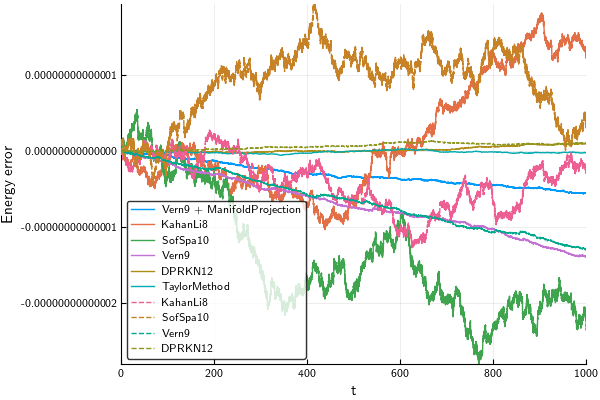

In [9]:
in_vs_out(dyn_only=false, tmax=1e3)

Now we will compare the in place and the out of place versions, but only for the integrators that are compatible with `StaticArrays`

In place versions:
  0.014036 seconds (190.21 k allocations: 10.319 MiB)
  0.016701 seconds (190.20 k allocations: 10.319 MiB)
  0.040826 seconds (1.58 M allocations: 26.838 MiB, 33.40% gc time)
  0.000608 seconds (8.55 k allocations: 394.016 KiB)
KahanLi8 max energy error:			4.9404924595819466e-15	in	10001	steps.
SofSpa10 max energy error:			5.440092820663267e-15	in	10001	steps.
Vern9 max energy error:				1.4988010832439613e-15	in	853	steps.
DPRKN12 max energy error:			2.498001805406602e-16	in	329	steps.

Out of place versions:
  0.005987 seconds (20.19 k allocations: 3.287 MiB)
  0.010813 seconds (20.18 k allocations: 3.288 MiB)
  0.001624 seconds (12.32 k allocations: 1.002 MiB)
  0.000490 seconds (4.30 k allocations: 241.141 KiB)
KahanLi8 max energy error:			2.7478019859472624e-15	in	10001	steps.
SofSpa10 max energy error:			4.6074255521944e-15	in	10001	steps.
Vern9 max energy error:				1.3600232051658168e-15	in	853	steps.
DPRKN12 max energy error:			1.6653345369377348e-16	in	329	s


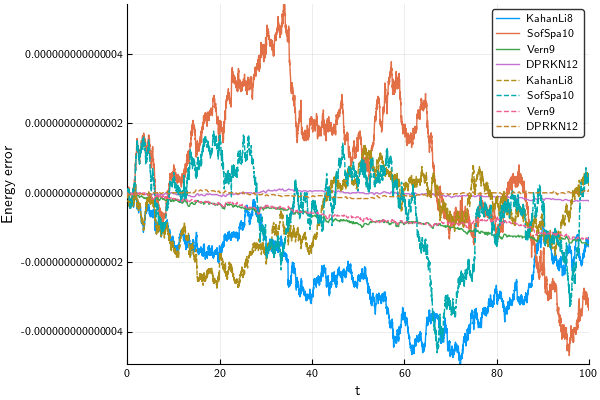

In [10]:
in_vs_out(tmax=1e2)

In place versions:
  0.257337 seconds (1.90 M allocations: 101.091 MiB, 50.49% gc time)
  0.367446 seconds (1.90 M allocations: 101.091 MiB, 47.63% gc time)
  0.386464 seconds (15.78 M allocations: 267.807 MiB, 36.41% gc time)
  0.005919 seconds (82.21 k allocations: 3.593 MiB)
KahanLi8 max energy error:			1.815214645262131e-14	in	100002	steps.
SofSpa10 max energy error:			2.8033131371785203e-14	in	100002	steps.
Vern9 max energy error:				1.3933298959045715e-14	in	8475	steps.
DPRKN12 max energy error:			1.0269562977782698e-15	in	3239	steps.

Out of place versions:
  0.066687 seconds (200.20 k allocations: 26.270 MiB, 7.26% gc time)
  0.112014 seconds (200.20 k allocations: 26.271 MiB, 5.32% gc time)
  0.014855 seconds (120.34 k allocations: 10.408 MiB)
  0.003876 seconds (40.45 k allocations: 2.080 MiB)
KahanLi8 max energy error:			1.2684298056342413e-14	in	100002	steps.
SofSpa10 max energy error:			1.9345636204093353e-14	in	100002	steps.
Vern9 max energy error:				1.304512053934559e-1


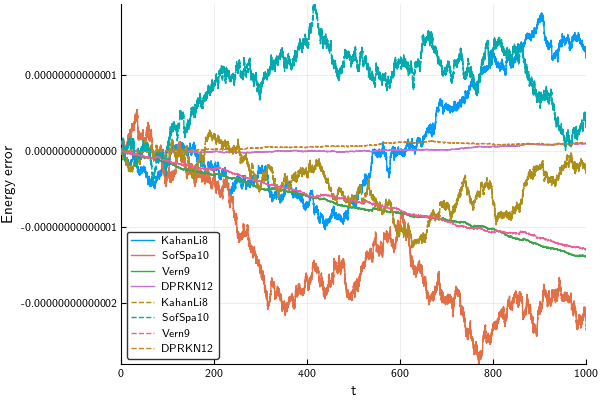

In [11]:
in_vs_out(tmax=1e3)

In place versions:
  2.433713 seconds (19.00 M allocations: 966.797 MiB, 48.90% gc time)
  5.049930 seconds (19.00 M allocations: 966.797 MiB, 61.33% gc time)
 19.718417 seconds (157.84 M allocations: 2.613 GiB, 81.30% gc time)
  0.093429 seconds (818.97 k allocations: 35.241 MiB, 34.74% gc time)
KahanLi8 max energy error:			3.161360062620133e-14	in	1000001	steps.
SofSpa10 max energy error:			1.136590821460004e-13	in	1000001	steps.
Vern9 max energy error:				1.22291066162461e-13	in	84653	steps.
DPRKN12 max energy error:			1.4988010832439613e-14	in	32348	steps.

Out of place versions:
  0.849043 seconds (2.00 M allocations: 208.599 MiB, 26.30% gc time)
  1.523757 seconds (2.00 M allocations: 212.600 MiB, 29.83% gc time)
  0.220057 seconds (1.20 M allocations: 97.305 MiB, 30.35% gc time)
  0.038984 seconds (402.82 k allocations: 19.795 MiB)
KahanLi8 max energy error:			5.5261351050717167e-14	in	1000001	steps.
SofSpa10 max energy error:			2.3342439092743916e-14	in	1000001	steps.
Vern9 max


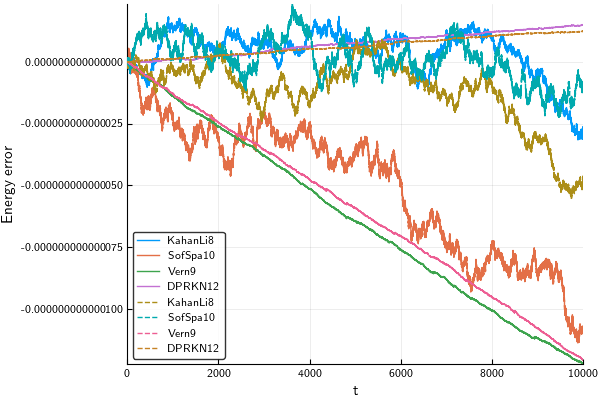

In [12]:
in_vs_out(tmax=1e4)

In [ ]:
in_vs_out(tmax=5e4)

As we see from the above comparisons, the `StaticArray` versions are significantly faster and use less memory. The speedup provided for the out of place version is more proeminent at larger `tmax`. The most remarkable is the case of `Vern9` at `tmax = 5e4` where the difference is greater that 100x.

The benchmarks were performed on a machine with

In [ ]:
versioninfo()